In [1]:
from datetime import datetime as dt
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
sys.path.append('../src/')
import helper

In [4]:
today = dt.today().isoformat().split("T")[0]
today

'2021-11-25'

In [5]:
datapath = '../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv'

In [6]:
ibm = pd.read_csv(datapath)

In [7]:
data_loader = helper.IBMData(datapath, verbose=True)
X, y = data_loader.separate_response


Split X and y...
self.X.shape (1470, 34)
self.y.shape (1470,)


In [8]:
data_pp = helper.PreProcess(X, verbose=True)
data_pp.preprocess_data()


The following categorical_columns have been label encoded: ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

The following categorical_columns have been binarized: ['Gender', 'Over18', 'OverTime']


In [9]:
preprocessed_X = data_pp.pp_X

preproccessed_X_and_y = pd.concat([preprocessed_X, y], axis=1)
preproccessed_X_and_y.shape

(1470, 35)

In [93]:
from sklearn.preprocessing import StandardScaler

In [94]:
std_sc = StandardScaler()

In [102]:
pp_stdsc_X = std_sc.fit_transform(preprocessed_X)
pp_stdsc_X_df = pd.DataFrame(pp_stdsc_X, columns=preprocessed_X.columns)

In [10]:
response_col = 'Attrition'

cat_num_cols = ["Education", "EnvironmentSatisfaction", "JobInvolvement",
                "JobLevel", "JobSatisfaction", "NumCompaniesWorked", "PerformanceRating", 
                "RelationshipSatisfaction", "StockOptionLevel", "TrainingTimesLastYear", "WorkLifeBalance"]

numeric_cols = [col for col in ibm.columns if (type(ibm.loc[0, col]) != str) 
                and (col not in cat_num_cols) 
                and (col != response_col)]

categoricals = [col for col in ibm.columns if (col not in numeric_cols) and 
                (col not in cat_num_cols) and 
                (col != response_col)]

#### Observations
- Certain of the numeric columns look to have uniform distribution 
    - DailyRate
    - Hourly Rate (likely highly colinear & highly correlated to DailyRate
    - Monthly Rate (likely highly colinear & highly correlated to DailyRate)
- Others look to have high skew 
    - Distance from Home
    - Percent Salary Hike
    - Monthly Income
    - Total Working Years
    - Years at Company
    - Years Since Last Promotion
- Bimodal / Multimodal distribution
    - Years in Current Role

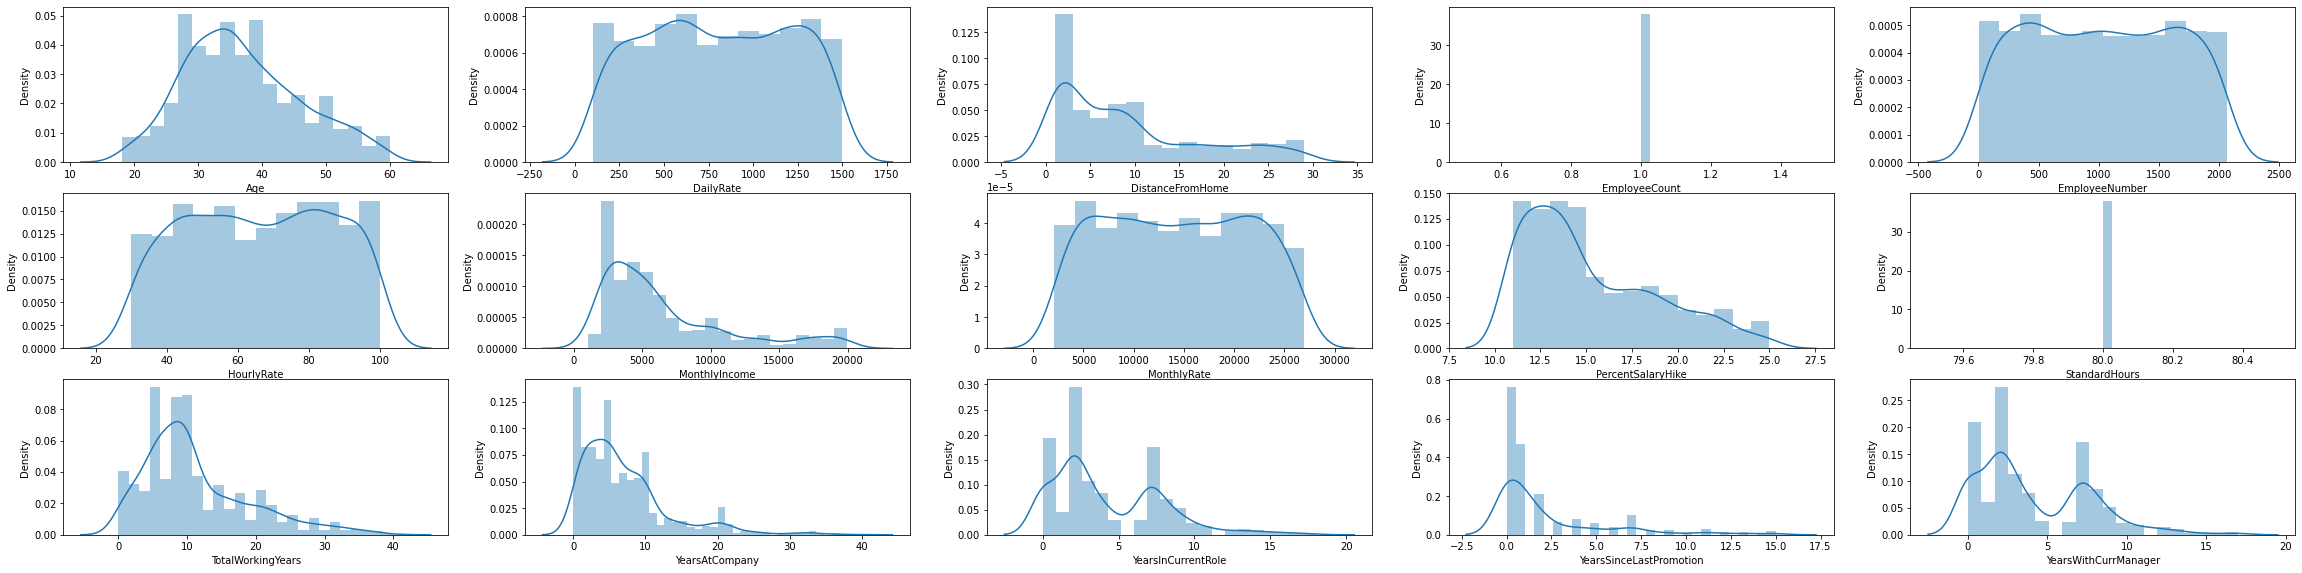

In [11]:
fig = plt.figure(1, figsize=(40, 20))
for i, col in enumerate(numeric_cols):
    fig.add_subplot(6, 5, i + 1)
    sns.distplot(ibm[col].dropna())
plt.show()
fig.savefig(f'../reports/ibm-distplots-{today}.png')

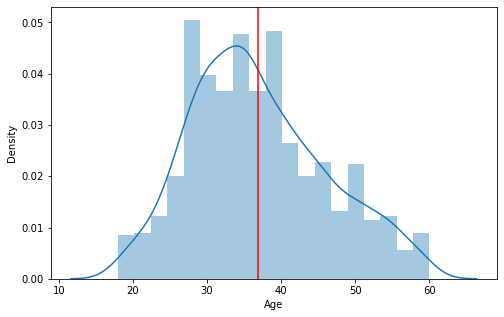

In [181]:
age_fig = plt.figure(1, figsize=(8, 5))
sns.distplot(ibm['Age'])
plt.axvline(ibm['Age'].mean(), color='red')
plt.show()
age_fig.savefig('../reports/figures/age-distribution.png')

count    1470.000000
mean       15.209524
std         3.659938
min        11.000000
25%        12.000000
50%        14.000000
75%        18.000000
max        25.000000
Name: PercentSalaryHike, dtype: float64

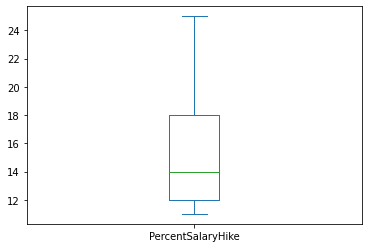

In [175]:
display(ibm['PercentSalaryHike'].describe())

ibm['PercentSalaryHike'].plot(kind='box')
plt.show()

In [71]:
ibm[['DailyRate', 'HourlyRate', 'MonthlyRate']].describe()

,DailyRate,HourlyRate,MonthlyRate
count,1470.000000,1470.000000,1470.000000
mean,802.485714,65.891156,14313.103401
std,403.509100,20.329428,7117.786044
min,102.000000,30.000000,2094.000000
25%,465.000000,48.000000,8047.000000
50%,802.000000,66.000000,14235.500000
75%,1157.000000,83.750000,20461.500000
max,1499.000000,100.000000,26999.000000


In [115]:
job_role = pd.DataFrame(ibm['JobRole'].value_counts()).reset_index()
job_role['Pct_Role'] = job_role['JobRole'] / 1470
job_role

,index,JobRole,Pct_Role
0,Sales Executive,326,0.221769
1,Research Scientist,292,0.198639
2,Laboratory Technician,259,0.176190
3,Manufacturing Director,145,0.098639
4,Healthcare Representative,131,0.089116
5,Manager,102,0.069388
6,Sales Representative,83,0.056463
7,Research Director,80,0.054422
8,Human Resources,52,0.035374


In [116]:
department = pd.DataFrame(ibm['Department'].value_counts()).reset_index()
department['Pct_Dept'] = department['Department'] / 1470
department

,index,Department,Pct_Dept
0,Research & Development,961,0.653741
1,Sales,446,0.303401
2,Human Resources,63,0.042857


In [110]:
preproccessed_X_and_y['JobRole'].value_counts()

7    326
6    292
2    259
4    145
0    131
3    102
8     83
5     80
1     52
Name: JobRole, dtype: int64

#### Correlation Analysis for Collinearity
- Interesting that the daily, hourly, and monthly rates do not have strong coorelation with one another (as one would have suspected previously)

In [144]:
corr = preproccessed_X_and_y.corr()

In [69]:
collinear_pairs = list()

for i, row in corr.iterrows():
    corr_cols = (np.where(row > 0.6))[0]
    pair = set()
    for j in corr_cols:
        if corr.loc[i, corr.columns[j]] != 1: 
            pair = set([i, corr.columns[j]])
            if pair not in collinear_pairs:
                collinear_pairs.append(pair) 

pprint(collinear_pairs)

[{'Age', 'TotalWorkingYears'},
 {'Department', 'JobRole'},
 {'MonthlyIncome', 'JobLevel'},
 {'TotalWorkingYears', 'JobLevel'},
 {'TotalWorkingYears', 'MonthlyIncome'},
 {'PerformanceRating', 'PercentSalaryHike'},
 {'YearsAtCompany', 'TotalWorkingYears'},
 {'YearsAtCompany', 'YearsInCurrentRole'},
 {'YearsAtCompany', 'YearsSinceLastPromotion'},
 {'YearsWithCurrManager', 'YearsAtCompany'},
 {'YearsWithCurrManager', 'YearsInCurrentRole'}]


In [82]:
ibm[['DailyRate', 'HourlyRate', 'MonthlyRate', 'MonthlyIncome']].sample(7)

,DailyRate,HourlyRate,MonthlyRate,MonthlyIncome
411,422,41,3854,19566
194,1195,65,20462,16792
926,531,56,20364,10231
947,1030,64,21534,8446
822,1003,95,15834,4033
1083,676,86,21831,2018
1265,775,90,6194,3055


#### Educational Impact

In [137]:
edu_levels = ibm['Education'].value_counts()

3    572
4    398
2    282
1    170
5     48
Name: Education, dtype: int64

In [150]:
ibm.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [170]:
ibm[ibm['Education'] == 1][['Age', 
                            'Education', 
                            'EducationField', 
                            'Department', 
                            'JobRole',
                            'JobLevel']]['JobRole'].value_counts()

Research Scientist           37
Laboratory Technician        35
Sales Executive              27
Sales Representative         20
Manufacturing Director       15
Healthcare Representative    15
Manager                       9
Research Director             7
Human Resources               5
Name: JobRole, dtype: int64

In [168]:
ibm[ibm['Education'] == 2][['Age', 
                            'Education', 
                            'EducationField', 
                            'Department', 
                            'JobRole',
                            'JobLevel']]['JobRole'].value_counts()

Sales Executive              66
Laboratory Technician        57
Research Scientist           46
Manufacturing Director       33
Healthcare Representative    21
Manager                      19
Sales Representative         15
Research Director            13
Human Resources              12
Name: JobRole, dtype: int64

In [169]:
ibm[ibm['Education'] >= 3][['Age', 
                            'Education', 
                            'EducationField', 
                            'Department', 
                            'JobRole',
                            'JobLevel']]['JobRole'].value_counts()

Sales Executive              233
Research Scientist           209
Laboratory Technician        167
Manufacturing Director        97
Healthcare Representative     95
Manager                       74
Research Director             60
Sales Representative          48
Human Resources               35
Name: JobRole, dtype: int64

In [160]:
ibm[ibm['Education'] == 2][['Age', 
                            'Education', 
                            'EducationField', 
                            'Department', 
                            'JobRole']]['JobRole'].value_counts()

Sales Executive              66
Laboratory Technician        57
Research Scientist           46
Manufacturing Director       33
Healthcare Representative    21
Manager                      19
Sales Representative         15
Research Director            13
Human Resources              12
Name: JobRole, dtype: int64

In [164]:
ibm[ibm['Education'] >= 3][['Age', 
                            'Education', 
                            'EducationField', 
                            'Department', 
                            'JobRole']]['JobRole'].value_counts()

Sales Executive              233
Research Scientist           209
Laboratory Technician        167
Manufacturing Director        97
Healthcare Representative     95
Manager                       74
Research Director             60
Sales Representative          48
Human Resources               35
Name: JobRole, dtype: int64

In [130]:
ibm['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

In [131]:
ibm['JobRole'].value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

In [134]:
ibm['EducationField'].value_counts()

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

In [143]:
edu_fields = ibm['EducationField'].unique().tolist()
job_roles = ibm['JobRole'].unique().tolist()
depts = ibm['Department'].unique().tolist()
edu_levels = ibm['Education'].unique().tolist()

edu_level_map = dict(zip([1, 2, 3, 4, 5], ['Below College', 'College', 'Bachelor', 'Master', 'Doctor']))
edu_level_map

{1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'}

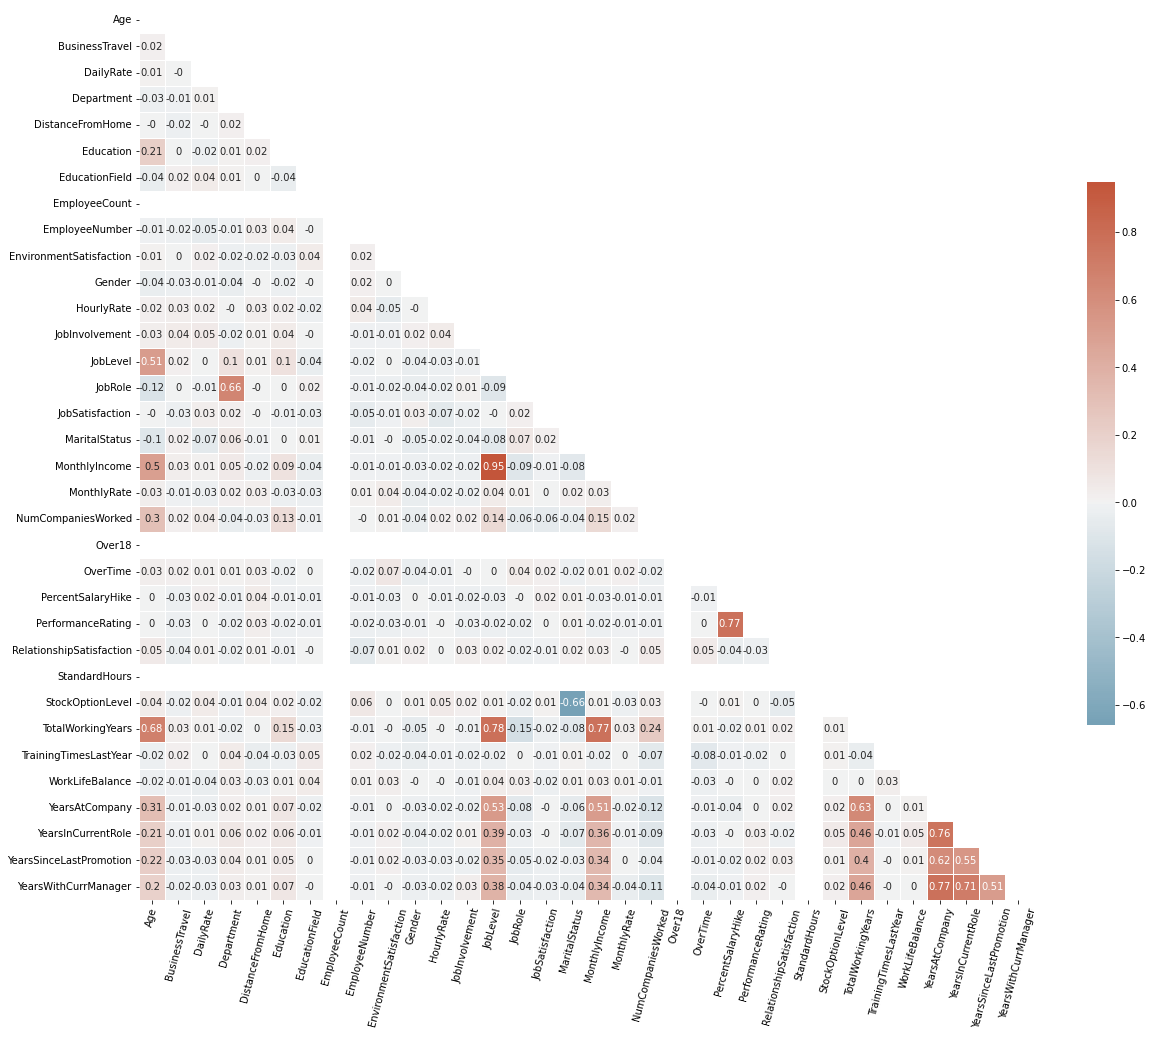

In [39]:
fig2 = plt.figure(1, figsize=(20, 20))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr.round(2),
            cbar=True,
            mask=mask,
            annot=True,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            cmap=sns.diverging_palette(230, 20, as_cmap=True))
plt.xticks(rotation=75)
plt.show()
fig2.savefig('../reports/figures/corr-heatmap-annot.png')

#### VIF (Variable Inflation Factor) to Measure Multilinearity
- Reference: https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f


**Observations**
- Employee Count is not a relevant feature as shown in the Correlation heatmap as well as the VIF table below.
- Over 18 is not a valuable attribute either 
- Standard hours is 

In [14]:
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})


In [23]:
vif_df = calculate_vif(preproccessed_X_and_y, preprocessed_X.columns)
multilin_feats = vif_df[vif_df['VIF'] > 10]
multilin_feats.index.tolist()

['EmployeeCount', 'JobLevel', 'MonthlyIncome', 'Over18', 'StandardHours']

In [126]:
vif_df_min_monthlyinc = calculate_vif(preproccessed_X_and_y_no_MI, 
                                      preproccessed_X_and_y_no_MI.columns)
multilin_feats_no_MI = vif_df_min_monthlyinc[vif_df_min_monthlyinc['VIF'] > 10]
multilin_feats_no_MI.index.tolist()

['EmployeeCount', 'Over18', 'StandardHours']

In [128]:
vif_df_min_monthlyinc.sort_values('VIF', ascending=False)

,VIF,Tolerance
StandardHours,inf,0.000000
EmployeeCount,inf,0.000000
Over18,inf,0.000000
TotalWorkingYears,4.734392,0.211220
YearsAtCompany,4.599876,0.217397
YearsWithCurrManager,2.766921,0.361413
JobLevel,2.759627,0.362368
YearsInCurrentRole,2.726903,0.366716
PercentSalaryHike,2.519656,0.396880
PerformanceRating,2.519351,0.396928


### Observations
- There are categorical attributes that are numerically represented, such as: 
    - Education: 1, 2, 3, 4, 5
    - Environment Satisfaction: 1, 2, 3, 4
    - Job Involvement: 1, 2, 3, 4
    - Job Level: 1, 2, 3, 4, 5
    - Job Satisfaction: 1, 2, 3, 4
    - Num Companies Worked: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    - Performance Rating: 3, 4
    - Relationship Satisfaction: 1, 2, 3, 4
    - Stock Option Level: 0, 1, 2, 3
    - Training Times Last Year: 0, 1, 2, 3, 4, 5, 6
    - Work Life balance: 1, 2, 3, 4

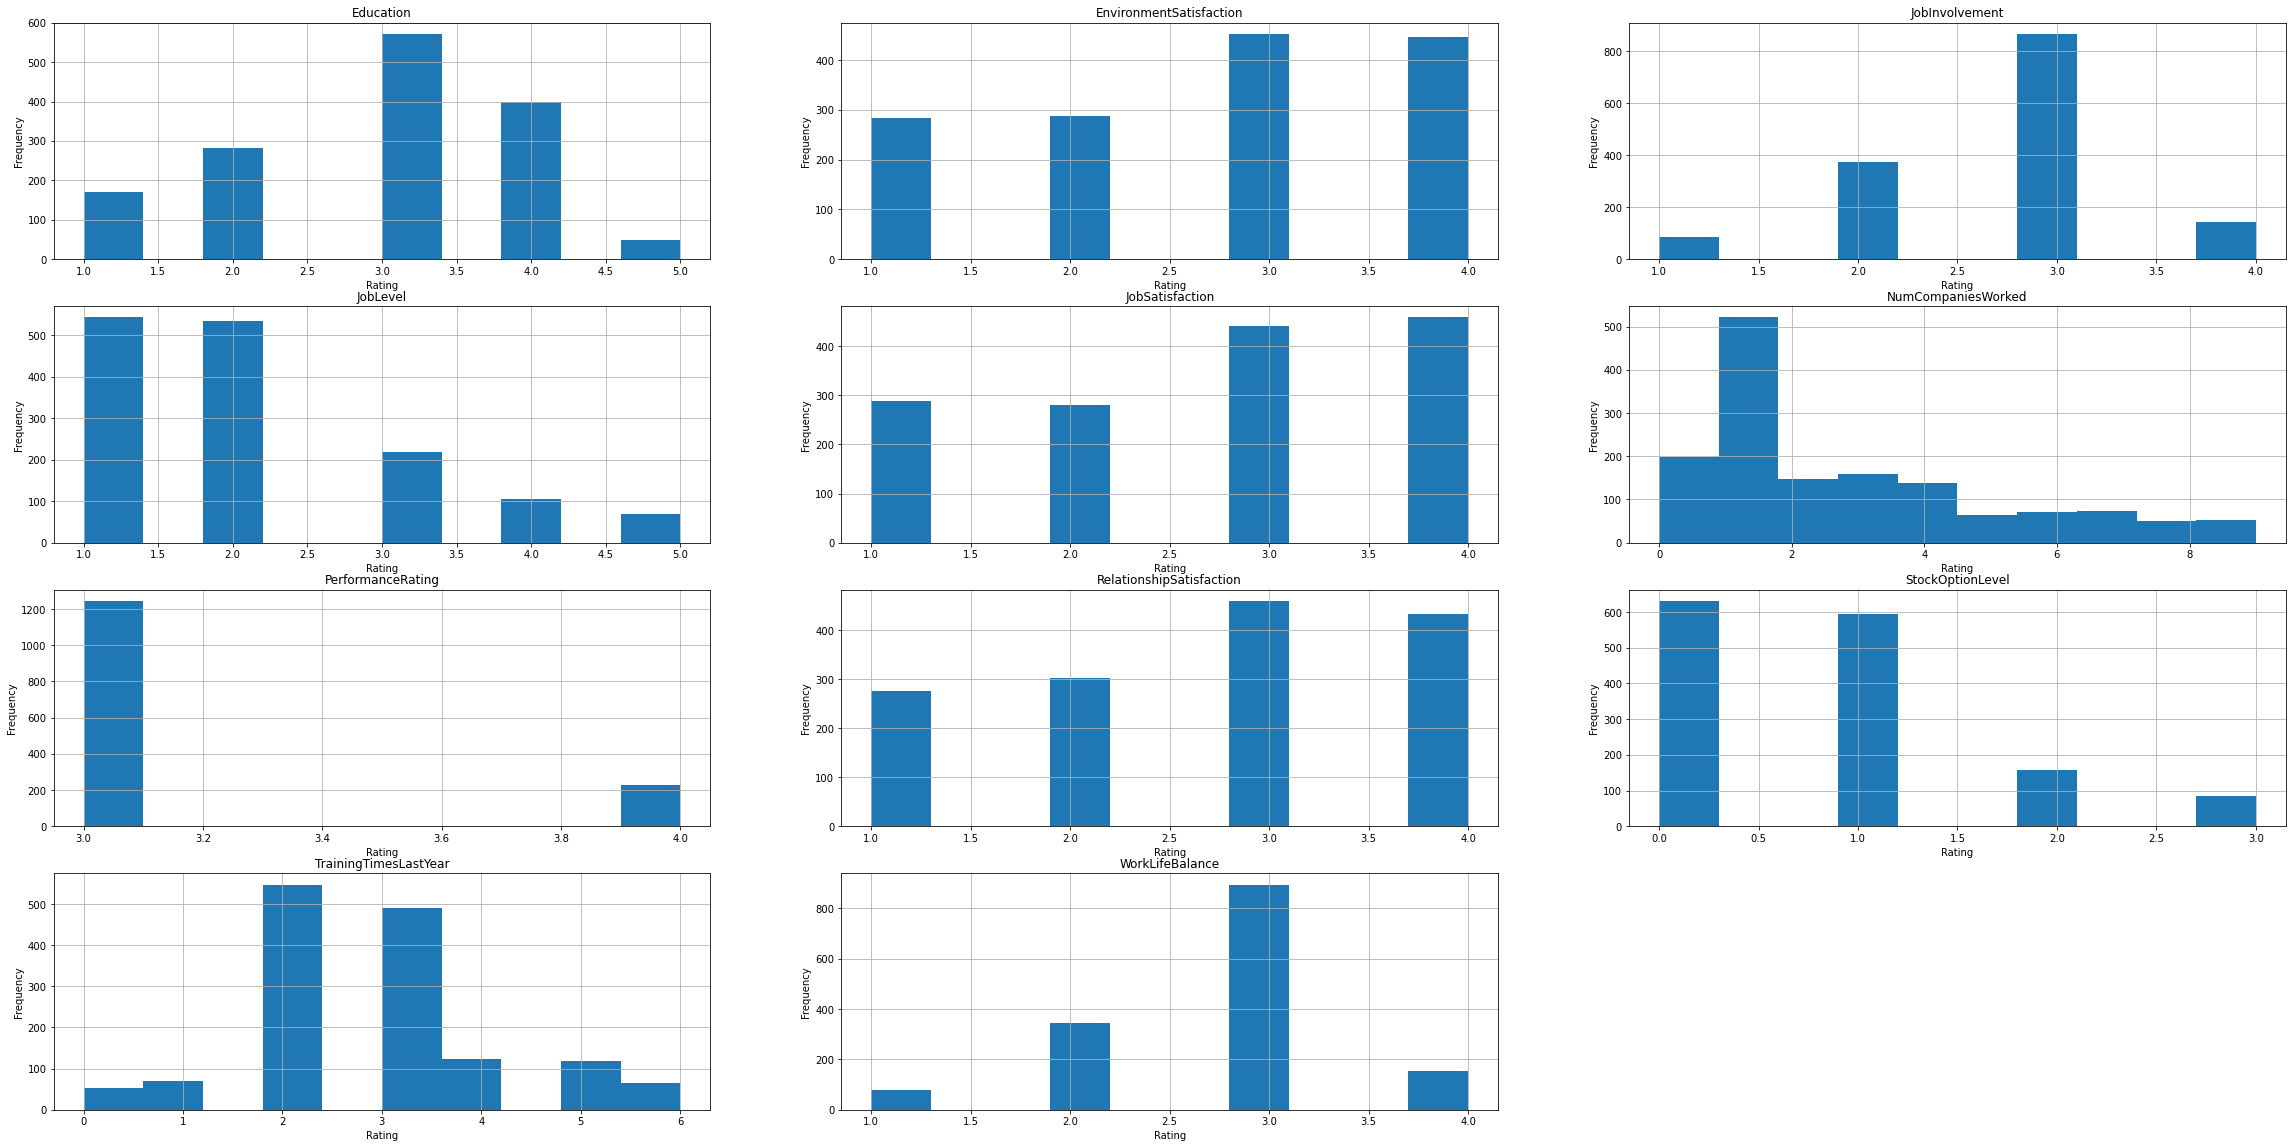

In [15]:
fig = plt.figure(1, figsize=(40, 20))
for i, col in enumerate(cat_num_cols):
    fig.add_subplot(4, 3, i+1)
    ibm[col].hist()
    plt.title(col)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
plt.show()
fig.savefig(f'../reports/ibm-numeric-categories-{today}.png')

<AxesSubplot:xlabel='WorkLifeBalance', ylabel='JobSatisfaction'>

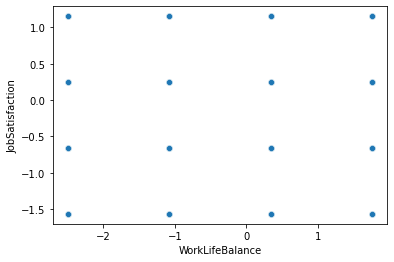

In [109]:
# Try to normalize this
sns.scatterplot(pp_stdsc_X_df['WorkLifeBalance'], pp_stdsc_X_df['JobSatisfaction'])

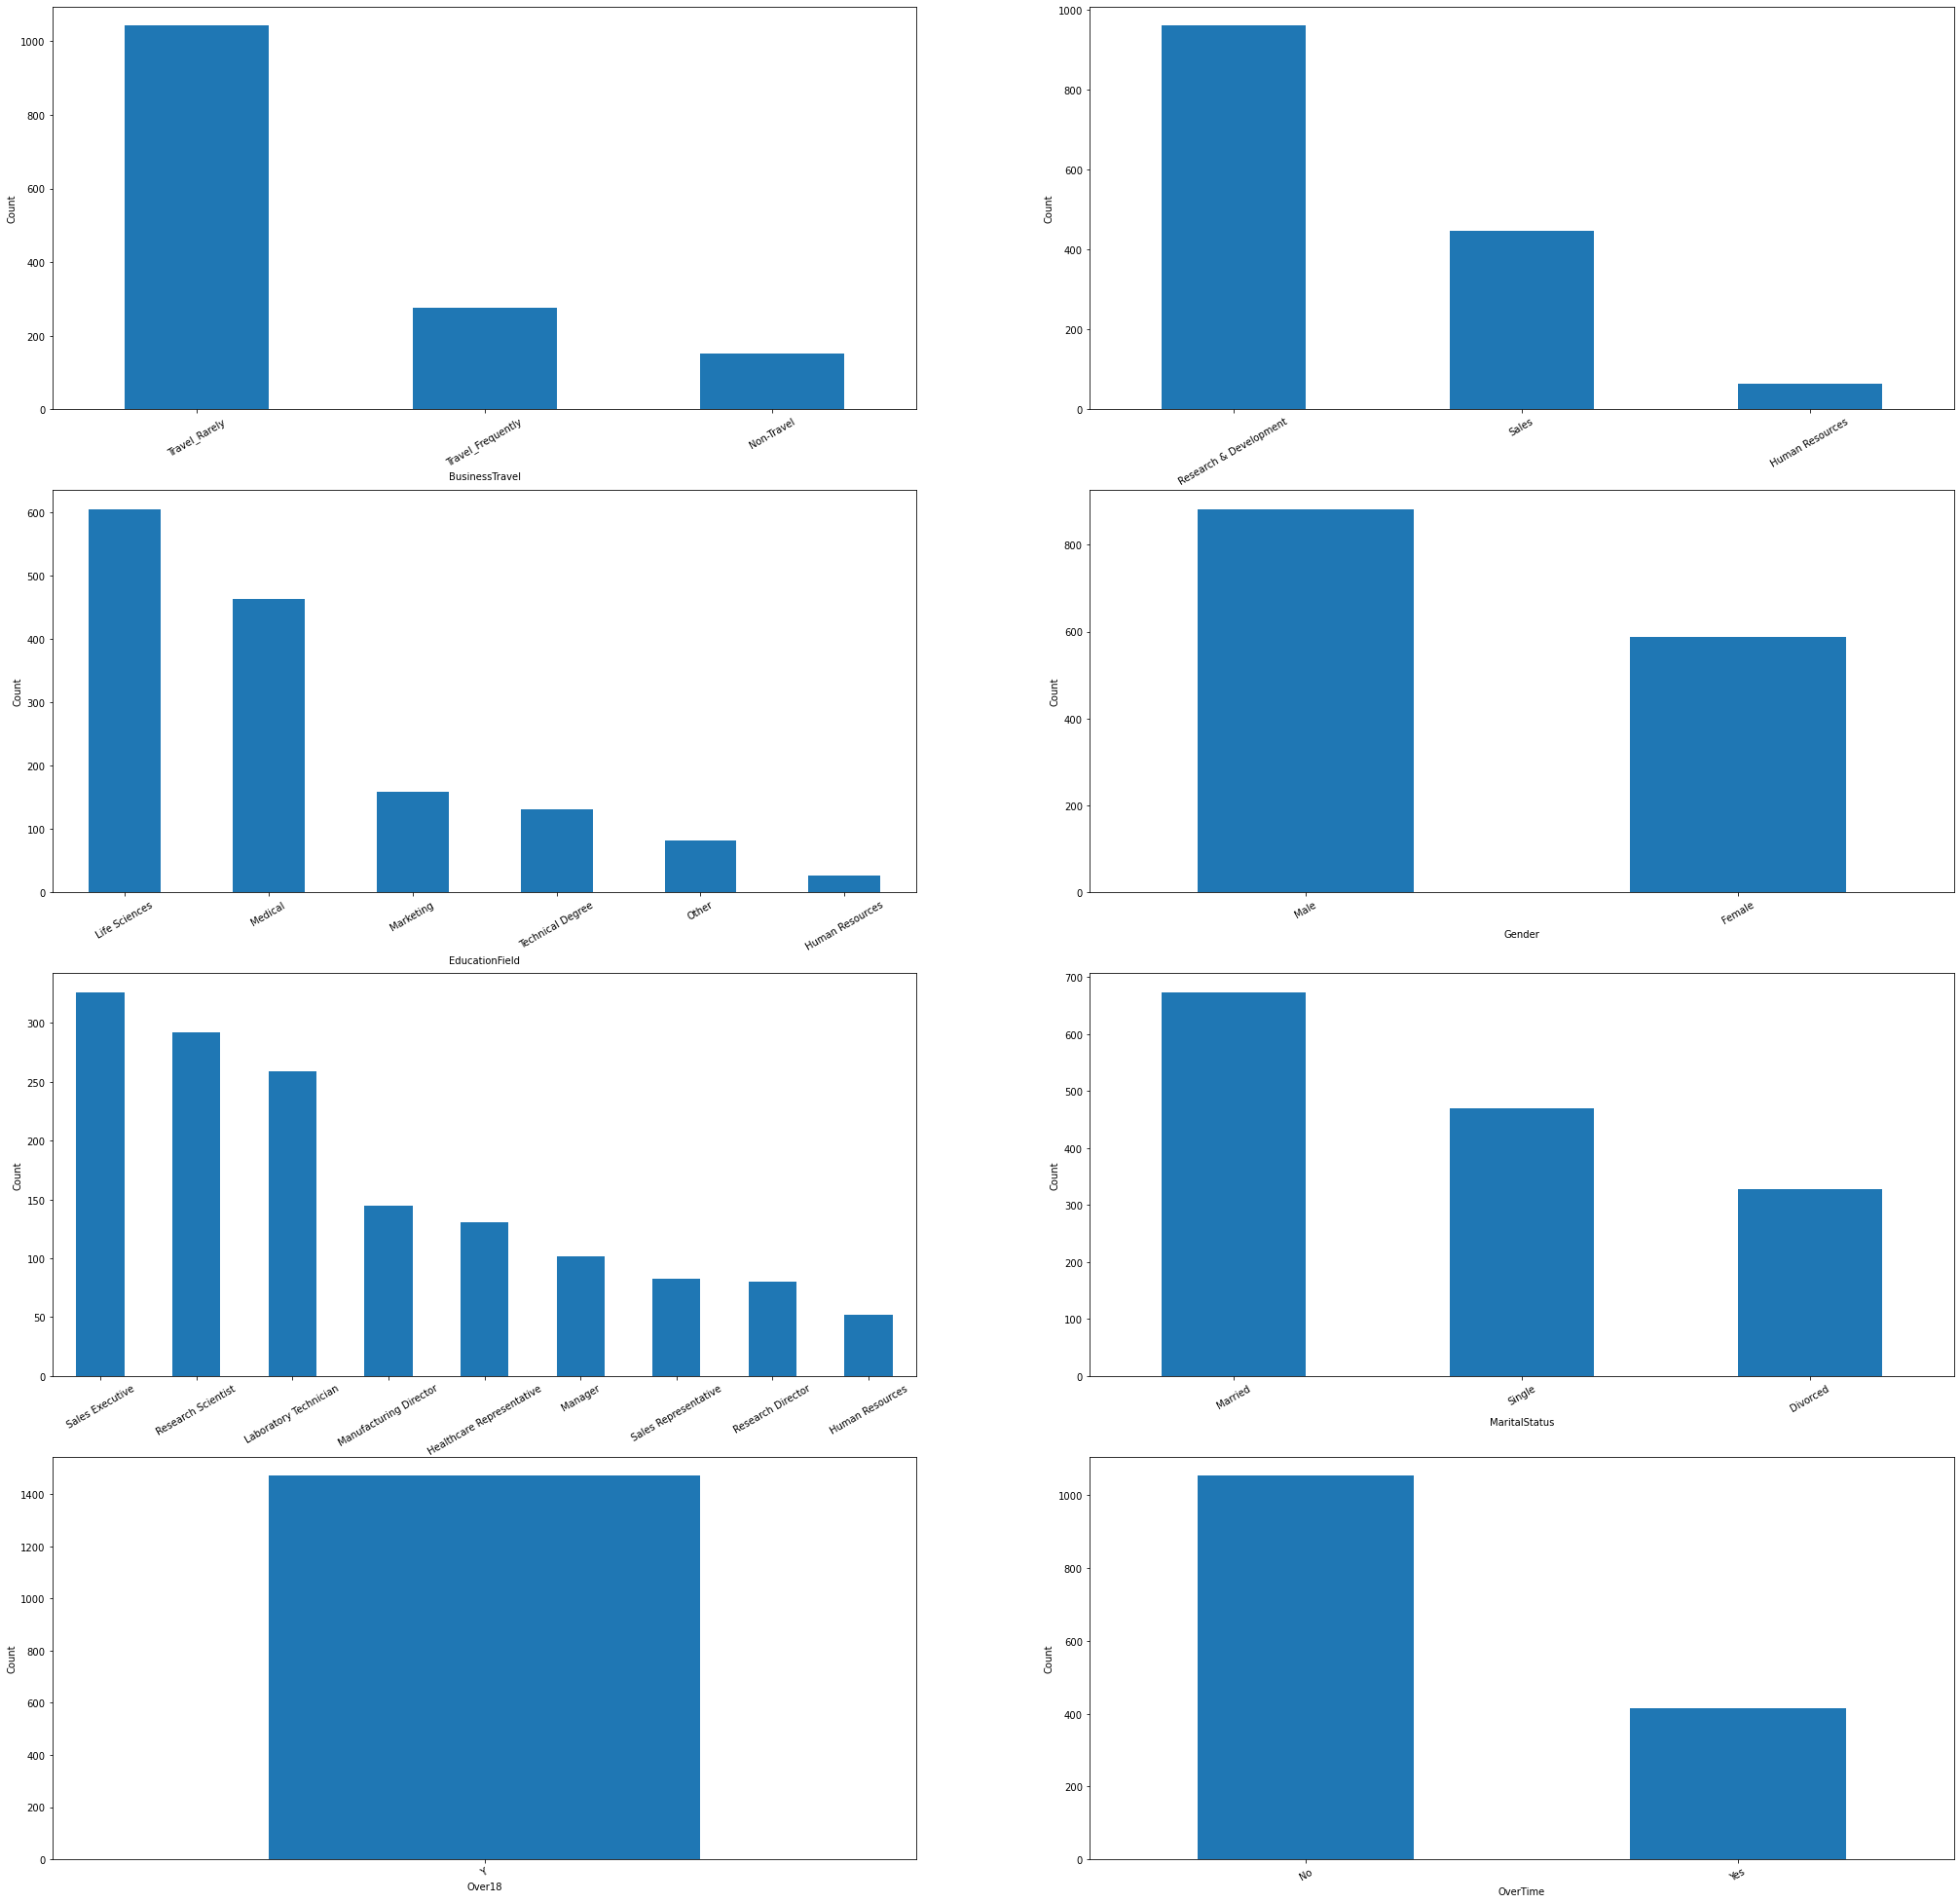

In [16]:
fig = plt.figure(1, figsize=(35, 35))
for i, col in enumerate(categoricals): 
    fig.add_subplot(4, 2, i+1)
    ibm[col].value_counts().plot(kind='bar')
    plt.xticks(rotation=30)
    plt.ylabel('Count')
    plt.xlabel(col)
plt.show()
fig.savefig(f'../reports/ibm-categorical-histograms-{today}.png')